In [12]:
from PIL import Image

# Load the image
img = Image.open('../figures/nhl_rink.png')

# Cut image in half to show right side and display
width, height = img.size
new_img = img.crop((width/2, 0, width, height))
new_img.save('../figures/nhl_rink_right.png')

In [1]:
from ift6758.visualizations import AdvancedVisualization

advancedVis = AdvancedVisualization("./../ift6758/data/json_clean/{season}/{season}.pkl")
df = advancedVis.load_season_data(2017)

In [2]:
df.team.unique()

array(['Winnipeg Jets', 'Toronto Maple Leafs', 'Pittsburgh Penguins',
       'St. Louis Blues', 'Edmonton Oilers', 'Calgary Flames',
       'San Jose Sharks', 'Philadelphia Flyers', 'Boston Bruins',
       'Nashville Predators', 'Montréal Canadiens', 'Buffalo Sabres',
       'Colorado Avalanche', 'New York Rangers', 'Washington Capitals',
       'Ottawa Senators', 'Minnesota Wild', 'Detroit Red Wings',
       'Chicago Blackhawks', 'Arizona Coyotes', 'Anaheim Ducks',
       'Los Angeles Kings', 'New York Islanders', 'Columbus Blue Jackets',
       'Florida Panthers', 'Tampa Bay Lightning', 'Dallas Stars',
       'Vegas Golden Knights', 'New Jersey Devils', 'Carolina Hurricanes',
       'Vancouver Canucks'], dtype=object)

In [2]:
team = 'Florida Panthers'
df_team = advancedVis.get_data_for_team(df, team)
df_team.sample(10)

,diff
2789,0.187155
8508,0.006523
9340,-0.003924
4399,0.047302
8692,0.030264
1910,-0.005695
6149,0.028511
613,0.004818
320,-0.014008
1648,-0.063845


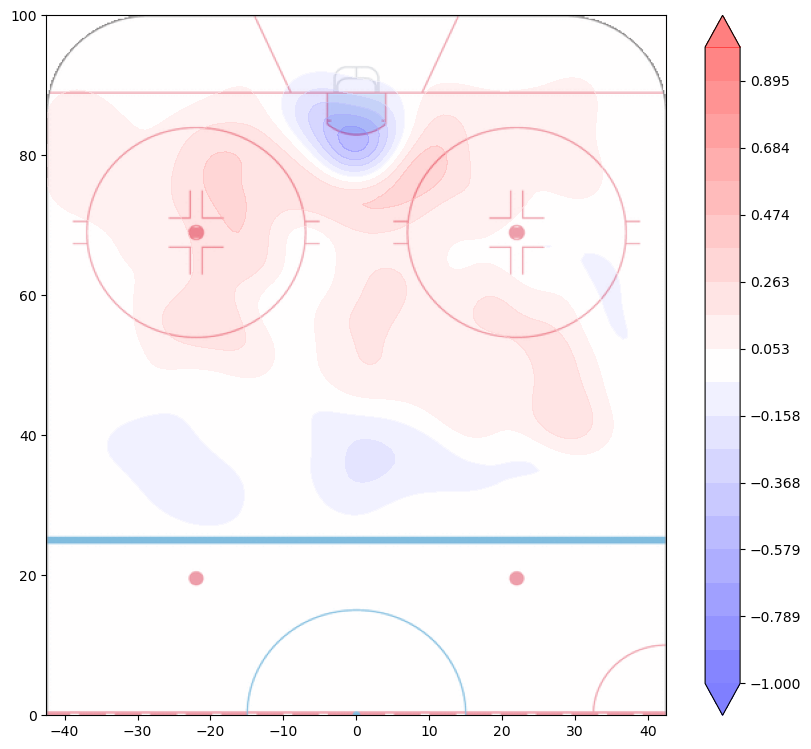

In [13]:
import numpy as np
import matplotlib.pyplot as plt

grid_size = 100
x = np.linspace(-42.5, 42.5, grid_size + 1)
y = np.linspace(0, 100, grid_size + 1)
z = df_team['diff'].to_numpy().reshape((grid_size + 1, grid_size + 1), order='F')

fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211)

cmap = plt.colormaps["bwr"].with_extremes(under="blue", over="red")
contour = ax1.contourf(x, y, z, alpha=0.5, levels=np.linspace(-1.0, 1.0, 20), cmap=cmap, extend='both')
fig.colorbar(contour, ax=ax1)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())

im = plt.imread('../figures/nhl_half_rink_vertical.png')
ax1.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

In [1]:
import plotly.graph_objects as go
from ipywidgets import widgets
import numpy as np
from ift6758.visualizations import AdvancedVisualization

av = AdvancedVisualization("./../ift6758/data/json_clean/{season}/{season}.pkl")

seasons = [2016, 2017, 2018, 2019, 2020]

# Get all unique teams across the seasons
all_teams = {season : [] for season in seasons}
for season in seasons:
    df = av.load_season_data(season)
    all_teams[season] = sorted(df.team.unique())


In [2]:
from IPython.display import display, clear_output

default_season = seasons[1]
default_team = 'Florida Panthers'

grid_size = 100
x = np.linspace(-42.5, 42.5, grid_size + 1)
y = np.linspace(0, 100, grid_size + 1)
z_default = av.get_plot_args(default_team, default_season)

fig = go.FigureWidget(
    layout=dict(
        width=1000,
        height=1000,
        xaxis=dict(
            range=[-42.5, 42.5],
            autorange=False,
            zeroline=False,
            showgrid=False,
            ticks='',
            showticklabels=True
        ),
        yaxis=dict(
            range=[0, 100],
            autorange=False,
            zeroline=False,
            showgrid=False,
            ticks='',
            showticklabels=True
        ),
        showlegend=True,
        hovermode='closest',
    )
)

# Create color scale (more white = closer to 0, more red/blue = closer to -1/1)
colorscale = [
    [0, 'rgb(0, 0, 255)'],
    [0.48, 'rgb(255, 255, 255)'],
    [0.52, 'rgb(255, 255, 255)'],
    [1, 'rgb(255, 0, 0)']
]

# Create heatmap 
fig.add_trace(
    go.Contour(
        x=x,
        y=y,
        z=z_default,
        colorscale=colorscale,
        showscale=True,
        opacity=1,
        contours=dict(
            start=-1.0,
            end=1.0,
            size=0.075,
            showlines=False
        ),
        zmin=-1.0,
        zmax=1.0,
    )
)

# Add background of rink image
fig.add_layout_image(
    dict(
        source='../figures/nhl_half_rink_vertical.png',
        xref="x",
        yref="y",
        x=-42.5,
        y=100,
        sizex=85,
        sizey=100,
        sizing="stretch",
        opacity=0.5,
        layer="above"
    )
)

# Add title
fig.update_layout(
    title_text='Heatmap of shot differential for {team} in {season}'.format(team=default_team, season=default_season),
    title_x=0.5,
    title_font_size=20
)

# Season slider selection
season_slider = widgets.SelectionSlider(
    options=seasons,
    value=default_season,
    description='Season',
    disabled=False,
    # continuous_update=True,
    orientation='horizontal',
    readout=True
)

# Team dropdown selection
team_dropdown = widgets.Dropdown(
    options=all_teams[default_season],
    value=default_team,
    # continuous_update=True,
    description='Team:',
    disabled=False,
)
    
# Update heatmap based on team selection and season selection
def update_heatmap(change):   
    team = team_dropdown.value
    season = season_slider.value
    print(f'Updating heatmap for {team} in {season}')
    z = av.get_plot_args(team, season)
    
    # replace heatmap with new heatmap
    with fig.batch_update():
        fig.data[0].z = z
        fig.update_layout(
            title_text=f'Heatmap of shot differential for {team} in {season}',
            title_x=0.5,
            title_font_size=20
        )
    
# Update team dropdown options based on season selection
def update_team_dropdown_options(change):
    season = season_slider.value
    team_dropdown.options = all_teams[season]
    team_dropdown.value = all_teams[season][0]
    
# Update team dropdown options based on season selection before updating heatmap in case team is not in new season
team_dropdown.observe(update_heatmap, names='value')
season_slider.observe(update_heatmap, names='value')
season_slider.observe(update_team_dropdown_options, names='value')

# Display widgets
container = widgets.VBox([season_slider, team_dropdown, fig])
display(container)
# fig.show()

Updating heatmap for Boston Bruins in 2017
